In [1]:
import os
import string
import numpy as np
import pandas as pd
from PIL import Image
from collections import Counter
from tqdm.notebook import tqdm 
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import matplotlib.pyplot as plt

In [2]:
# --- Configuration ---
BASE_DIR = '/kaggle/input/flickr8k/' # IMPORTANT: Update this path
IMAGES_PATH = os.path.join(BASE_DIR, 'Images')
CAPTIONS_FILE = os.path.join(BASE_DIR, 'captions.txt')

# Model Hyperparameters
EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_LAYERS = 1 # LSTM layers
LEARNING_RATE = 0.001
BATCH_SIZE = 64 # Adjust based on GPU memory
NUM_EPOCHS = 10 # Start with fewer epochs, e.g., 10-20
VOCAB_FREQ_THRESHOLD = 5 # Words appearing less than this are treated as <UNK>
EARLY_STOPPING_PATIENCE = 2

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Loading raw captions...
Checking image files in /kaggle/input/flickr8k/Images...
Found 8091 images with corresponding caption entries.
Cleaning captions...


  0%|          | 0/8091 [00:00<?, ?it/s]

Finished cleaning. Kept 8091 images with non-empty captions.
Building vocabulary...
Total unique words found: 8571
Vocabulary Size (>= 5 occurrences): 2889
Creating dataset...
Verifying image files and creating pairs...


  0%|          | 0/8091 [00:00<?, ?it/s]

Created 40455 (image, caption) pairs.
Train examples: 32364
Validation examples: 4045
Creating dataloaders...
Initializing models, loss, and optimizer...


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 107MB/s] 


Starting training for max 10 epochs (Patience: 2)...


Epoch 1/10 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

--- Epoch 1 Train Finished (Duration: 165.50s) --- Average Loss: 3.7980 ---


Epoch 1/10 [Validate]:   0%|          | 0/64 [00:00<?, ?it/s]

--- Epoch 1 Validation Finished (Duration: 17.02s) --- Average Loss: 3.1887 ---
Validation loss improved (inf --> 3.1887). Saving model...


Epoch 2/10 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

--- Epoch 2 Train Finished (Duration: 137.50s) --- Average Loss: 2.9867 ---


Epoch 2/10 [Validate]:   0%|          | 0/64 [00:00<?, ?it/s]

--- Epoch 2 Validation Finished (Duration: 17.54s) --- Average Loss: 2.9108 ---
Validation loss improved (3.1887 --> 2.9108). Saving model...


Epoch 3/10 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

--- Epoch 3 Train Finished (Duration: 137.69s) --- Average Loss: 2.6935 ---


Epoch 3/10 [Validate]:   0%|          | 0/64 [00:00<?, ?it/s]

--- Epoch 3 Validation Finished (Duration: 16.99s) --- Average Loss: 2.7782 ---
Validation loss improved (2.9108 --> 2.7782). Saving model...


Epoch 4/10 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

--- Epoch 4 Train Finished (Duration: 135.47s) --- Average Loss: 2.4828 ---


Epoch 4/10 [Validate]:   0%|          | 0/64 [00:00<?, ?it/s]

--- Epoch 4 Validation Finished (Duration: 17.69s) --- Average Loss: 2.7093 ---
Validation loss improved (2.7782 --> 2.7093). Saving model...


Epoch 5/10 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

--- Epoch 5 Train Finished (Duration: 137.14s) --- Average Loss: 2.3003 ---


Epoch 5/10 [Validate]:   0%|          | 0/64 [00:00<?, ?it/s]

--- Epoch 5 Validation Finished (Duration: 17.43s) --- Average Loss: 2.6756 ---
Validation loss improved (2.7093 --> 2.6756). Saving model...


Epoch 6/10 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

--- Epoch 6 Train Finished (Duration: 135.98s) --- Average Loss: 2.1348 ---


Epoch 6/10 [Validate]:   0%|          | 0/64 [00:00<?, ?it/s]

--- Epoch 6 Validation Finished (Duration: 16.94s) --- Average Loss: 2.6588 ---
Validation loss improved (2.6756 --> 2.6588). Saving model...


Epoch 7/10 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

--- Epoch 7 Train Finished (Duration: 138.96s) --- Average Loss: 1.9782 ---


Epoch 7/10 [Validate]:   0%|          | 0/64 [00:00<?, ?it/s]

--- Epoch 7 Validation Finished (Duration: 17.51s) --- Average Loss: 2.6606 ---
Validation loss did not improve for 1 epoch(s). Current best: 2.6588


Epoch 8/10 [Train]:   0%|          | 0/506 [00:00<?, ?it/s]

--- Epoch 8 Train Finished (Duration: 138.44s) --- Average Loss: 1.8293 ---


Epoch 8/10 [Validate]:   0%|          | 0/64 [00:00<?, ?it/s]

--- Epoch 8 Validation Finished (Duration: 17.39s) --- Average Loss: 2.6755 ---
Validation loss did not improve for 2 epoch(s). Current best: 2.6588

Early stopping triggered after 2 epochs without improvement.

Loading best model saved to 'best_caption_model_earlystop.pth' for example generation...


/tmp/ipykernel_31/3131565710.py:286: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_save_path, map_location=device)


Model loaded from epoch 6 with val_loss 2.6588

--- Generating caption for example image: /kaggle/input/flickr8k/Images/3578477508_b7d839da16.jpg ---
True Captions (cleaned):
  - boy wearing skates sliding down concrete railing of steps near pole
  - man is rollerblading down wall beside some steps
  - man is rollerskating down the wall next to some white steps
  - man on rollerblades grinding down concrete handrail
  - young man navigates sloped wall with inline skates


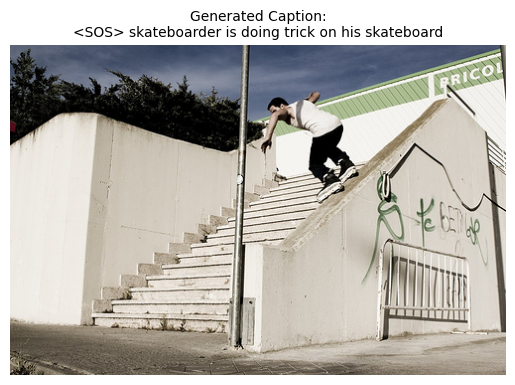


Generated Caption (using loaded model): <SOS> skateboarder is doing trick on his skateboard


In [3]:
# --- 1. Load and Preprocess Captions ---
def load_captions(filename):
    captions_map = {}
    with open(filename, 'r') as f:
        next(f) 
        for line in f:
            parts = line.strip().split(',')
            image_id_full = parts[0]
            image_id = os.path.splitext(os.path.basename(image_id_full))[0]
            caption = parts[1]
            if image_id not in captions_map:
                captions_map[image_id] = []
            captions_map[image_id].append(caption)
    return captions_map

def clean_captions(captions_map):
    cleaned_captions_map = {}
    table = str.maketrans('', '', string.punctuation)
    all_words_for_vocab = []
    print("Cleaning captions...")
    for img_id, caption_list in tqdm(captions_map.items()):
        cleaned_captions = []
        for caption in caption_list:
            caption = caption.lower()
            caption = caption.translate(table)
            words = [word for word in caption.split() if word.isalpha() and len(word)>1]
            cleaned_caption_text = ' '.join(words)
            cleaned_captions.append(cleaned_caption_text)
            all_words_for_vocab.extend(words)
        if cleaned_captions:
            cleaned_captions_map[img_id] = cleaned_captions
    return cleaned_captions_map, all_words_for_vocab

print("Loading raw captions...")
raw_captions_map = load_captions(CAPTIONS_FILE)
print(f"Checking image files in {IMAGES_PATH}...")
image_files = {f.split('.')[0] for f in os.listdir(IMAGES_PATH) if f.endswith('.jpg')}
captions_map_filtered = {img_id: caps for img_id, caps in raw_captions_map.items() if img_id in image_files}
print(f"Found {len(captions_map_filtered)} images with corresponding caption entries.")
cleaned_captions_map, all_words = clean_captions(captions_map_filtered)
print(f"Finished cleaning. Kept {len(cleaned_captions_map)} images with non-empty captions.")


# --- 2. Build Vocabulary ---
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {s: i for i, s in self.itos.items()}
        self.freq_threshold = freq_threshold
    def __len__(self): return len(self.itos)
    def build_vocabulary(self, sentence_word_list):
        frequencies = Counter(sentence_word_list)
        print(f"Total unique words found: {len(frequencies)}")
        idx = 4
        sorted_freq = sorted(frequencies.items(), key=lambda x: x[1], reverse=True)
        for word, count in sorted_freq:
            if count >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1
    def numericalize(self, text):
        tokenized_text = text.split()
        return [self.stoi.get(token, self.stoi["<UNK>"]) for token in tokenized_text]

print("Building vocabulary...")
vocab = Vocabulary(freq_threshold=VOCAB_FREQ_THRESHOLD)
vocab.build_vocabulary(all_words)
vocab_size = len(vocab)
print(f"Vocabulary Size (>= {VOCAB_FREQ_THRESHOLD} occurrences): {vocab_size}")
pad_idx = vocab.stoi["<PAD>"]


# --- 3. Prepare Dataset and DataLoader ---
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
class FlickrDataset(data.Dataset):
    def __init__(self, image_dir, captions_map, vocab, transform=None):
        self.image_dir = image_dir
        self.vocab = vocab
        self.transform = transform
        self.img_ids = list(captions_map.keys())
        self.img_caption_pairs = []
        print("Verifying image files and creating pairs...")
        for img_id in tqdm(self.img_ids):
            img_path = os.path.join(self.image_dir, img_id + '.jpg')
            if os.path.exists(img_path):
                for caption in captions_map[img_id]:
                     self.img_caption_pairs.append((img_id, caption))
        print(f"Created {len(self.img_caption_pairs)} (image, caption) pairs.")
    def __len__(self): return len(self.img_caption_pairs)
    def __getitem__(self, index):
        img_id, caption_text = self.img_caption_pairs[index]
        img_path = os.path.join(self.image_dir, img_id + '.jpg')
        image = Image.open(img_path).convert("RGB")
        if self.transform: image = self.transform(image)
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption.extend(self.vocab.numericalize(caption_text))
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        caption_tensor = torch.tensor(numericalized_caption)
        return image, caption_tensor, img_id
class Collate:
    def __init__(self, pad_idx): self.pad_idx = pad_idx
    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        targets = [item[1] for item in batch]
        img_ids = [item[2] for item in batch]
        imgs = torch.cat(imgs, dim=0)
        lengths = torch.tensor([len(cap) for cap in targets])
        targets_padded = nn.utils.rnn.pad_sequence(targets, batch_first=True, padding_value=self.pad_idx)
        return imgs, targets_padded, lengths, img_ids

print("Creating dataset...")
dataset = FlickrDataset(IMAGES_PATH, cleaned_captions_map, vocab, transform)
generator = torch.Generator().manual_seed(42)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, _ = data.random_split(dataset, [train_size, val_size, test_size], generator=generator)
test_indices = _.indices
print(f"Train examples: {len(train_dataset)}")
print(f"Validation examples: {len(val_dataset)}")
print("Creating dataloaders...")
collate_fn = Collate(pad_idx)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=2, pin_memory=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=2, pin_memory=True)


# --- 4. Define Models (Encoder and Decoder) ---
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_cnn=False):
        super(EncoderCNN, self).__init__()
        mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        for param in mobilenet.parameters(): param.requires_grad_(False)
        modules = list(mobilenet.children())[:-1]
        self.mobilenet_features = nn.Sequential(*modules)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(mobilenet.last_channel, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        if train_cnn:
            for param in self.mobilenet_features.parameters(): param.requires_grad_(True)
    def forward(self, images):
        features = self.mobilenet_features(images)
        features = self.adaptive_pool(features); features = features.view(features.size(0), -1)
        features = self.linear(features); features = self.bn(features); return features
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
    def forward(self, features, captions, lengths):
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)
        packed = pack_padded_sequence(embeddings, lengths.cpu(), batch_first=True, enforce_sorted=False)
        hiddens, _ = self.lstm(packed); outputs = self.linear(hiddens.data); return outputs
    def sample(self, features, max_len=30):
        generated_caption_indices = []
        states = None; inputs = features.unsqueeze(1)
        for _ in range(max_len):
            hiddens, states = self.lstm(inputs, states)
            outputs = self.linear(hiddens.squeeze(1)); predicted_index = outputs.argmax(1)
            if predicted_index.item() == vocab.stoi["<EOS>"]: break
            generated_caption_indices.append(predicted_index.item())
            inputs = self.embed(predicted_index).unsqueeze(1)
        return generated_caption_indices


# --- 5. Initialize Model, Loss, Optimizer ---
print("Initializing models, loss, and optimizer...")
encoder = EncoderCNN(EMBED_SIZE).to(device)
decoder = DecoderRNN(EMBED_SIZE, HIDDEN_SIZE, vocab_size, NUM_LAYERS).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = optim.Adam(params, lr=LEARNING_RATE)
model_save_path = 'best_caption_model_earlystop.pth' # Define model save path


# --- 6. Training Loop ---

print(f"Starting training for max {NUM_EPOCHS} epochs (Patience: {EARLY_STOPPING_PATIENCE})...")
best_val_loss = float('inf')
epochs_no_improve = 0 # <<< Initialize counter for early stopping

for epoch in range(NUM_EPOCHS):
    # --- Training Phase ---
    encoder.train()
    decoder.train()
    total_train_loss = 0
    num_train_batches = 0
    start_epoch_time = time.time()

    for i, batch_data in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")):
        images, captions_padded, lengths, _ = batch_data
        images = images.to(device)
        captions_padded = captions_padded.to(device)
        optimizer.zero_grad()
        features = encoder(images)
        decoder_input = captions_padded[:, :-1]
        outputs = decoder(features, decoder_input, lengths)
        targets = captions_padded
        packed_targets = pack_padded_sequence(targets, lengths.cpu(), batch_first=True, enforce_sorted=False)
        loss = criterion(outputs, packed_targets.data)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        num_train_batches += 1

    avg_train_loss = total_train_loss / num_train_batches if num_train_batches > 0 else 0
    epoch_duration = time.time() - start_epoch_time
    print(f"--- Epoch {epoch+1} Train Finished (Duration: {epoch_duration:.2f}s) --- Average Loss: {avg_train_loss:.4f} ---")

    # --- Validation Phase ---
    encoder.eval()
    decoder.eval()
    total_val_loss = 0
    num_val_batches = 0
    start_val_time = time.time()
    with torch.no_grad():
        for batch_data in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Validate]"):
             images, captions_padded, lengths, _ = batch_data
             images = images.to(device)
             captions_padded = captions_padded.to(device)
             features = encoder(images)
             decoder_input = captions_padded[:, :-1]
             outputs = decoder(features, decoder_input, lengths)
             targets = captions_padded
             packed_targets = pack_padded_sequence(targets, lengths.cpu(), batch_first=True, enforce_sorted=False)
             loss = criterion(outputs, packed_targets.data)
             total_val_loss += loss.item()
             num_val_batches += 1

    avg_val_loss = total_val_loss / num_val_batches if num_val_batches > 0 else 0
    val_duration = time.time() - start_val_time
    print(f"--- Epoch {epoch+1} Validation Finished (Duration: {val_duration:.2f}s) --- Average Loss: {avg_val_loss:.4f} ---")

    # --- Early Stopping Logic ---
    if avg_val_loss < best_val_loss:
        print(f"Validation loss improved ({best_val_loss:.4f} --> {avg_val_loss:.4f}). Saving model...")
        best_val_loss = avg_val_loss
        torch.save({
            'encoder_state_dict': encoder.state_dict(),
            'decoder_state_dict': decoder.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'vocab': vocab,
            'epoch': epoch,
            'val_loss': avg_val_loss,
        }, model_save_path)
        epochs_no_improve = 0 # Reset counter
    else:
        epochs_no_improve += 1 # Increment counter
        print(f"Validation loss did not improve for {epochs_no_improve} epoch(s). Current best: {best_val_loss:.4f}")

    if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
        print(f"\nEarly stopping triggered after {EARLY_STOPPING_PATIENCE} epochs without improvement.")
        break




# --- 8. Example: Generate caption for a single image ---
def generate_caption(image_path, encoder, decoder, vocab, transform, device, max_len=30):
    encoder.eval(); decoder.eval()
    if not os.path.exists(image_path):
         print(f"Error: Image not found at {image_path}"); return None
    image = Image.open(image_path).convert("RGB")
    image_transformed = transform(image).unsqueeze(0).to(device)
    caption_text = "(Generation failed)"
    with torch.no_grad():
        features = encoder(image_transformed)
        predicted_indices = decoder.sample(features, max_len=max_len)
    predicted_words = [vocab.itos[idx] for idx in predicted_indices]
    caption_text = ' '.join(predicted_words)
    img_display = Image.open(image_path); plt.imshow(img_display)
    plt.title(f"Generated Caption:\n{caption_text}", fontsize=10); plt.axis('off'); plt.show()
    return caption_text


# --- Load best model and generate example ---
print(f"\nLoading best model saved to '{model_save_path}' for example generation...")

if os.path.exists(model_save_path):
    checkpoint = torch.load(model_save_path, map_location=device)
    saved_vocab = checkpoint['vocab']
    # Re-initialize models before loading state dicts is good practice
    encoder = EncoderCNN(EMBED_SIZE).to(device)
    decoder = DecoderRNN(EMBED_SIZE, HIDDEN_SIZE, len(saved_vocab), NUM_LAYERS).to(device)
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    print(f"Model loaded from epoch {checkpoint.get('epoch', 'N/A')+1} with val_loss {checkpoint.get('val_loss', 'N/A'):.4f}") # +1 for user-friendly epoch number

    if test_indices:
         sample_original_idx = np.random.choice(test_indices)
         _, _, sample_img_id = dataset[sample_original_idx]
         test_image_path = os.path.join(IMAGES_PATH, sample_img_id + '.jpg')
         print(f"\n--- Generating caption for example image: {test_image_path} ---")
         print("True Captions (cleaned):")
         true_caps = cleaned_captions_map.get(sample_img_id, ["(Not found)"])
         for cap in true_caps: print(f"  - {cap}")
         generated_caption = generate_caption(test_image_path, encoder, decoder, saved_vocab, transform, device)
         print(f"\nGenerated Caption (using loaded model): {generated_caption}")
    else:
         print("\nTest indices not available, cannot generate random sample caption.")
else:
    print(f"\nModel file '{model_save_path}' not found. Cannot generate example. Was training run?")




## BLIP-2 Model

In [4]:
!pip install transformers torch torchvision accelerate Pillow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:01m00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.3 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 24.12.0 requires rmm-cu12==24.12.*, but you have rmm

In [5]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration

2025-04-16 18:57:13.831013: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744829834.324546      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744829834.449021      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
BLIP2_MODEL_NAME = "Salesforce/blip2-opt-2.7b"

In [7]:
# Use standard PIL loader for BLIP comparison later
blip_transform = transforms.Compose([
    transforms.Resize((224, 224)), # BLIP often uses direct 224 resize
])

In [8]:
# --- Function to load image ---
def load_image(image_path_or_url):
    """Loads an image from a local path or URL."""
    if os.path.exists(image_path_or_url):
        print(f"Loading image from local path: {image_path_or_url}")
        img = Image.open(image_path_or_url).convert('RGB')
    elif image_path_or_url.startswith("http://") or image_path_or_url.startswith("https://"):
        print(f"Downloading image from URL: {image_path_or_url}")
        img = Image.open(requests.get(image_path_or_url, stream=True).raw).convert('RGB')
    else:
        print(f"Error: Invalid image path or URL: {image_path_or_url}")
        return None
    return img

In [9]:
print(f"Loading BLIP-2 model: {BLIP2_MODEL_NAME}...")
load_dtype = torch.float16 if device == "cuda" else torch.float32
processor = Blip2Processor.from_pretrained(BLIP2_MODEL_NAME, use_fast=True)

blip_model = Blip2ForConditionalGeneration.from_pretrained(
        BLIP2_MODEL_NAME, torch_dtype=load_dtype
    )
blip_processor = Blip2Processor.from_pretrained(BLIP2_MODEL_NAME)

# Move the model to the designated device *after* loading with dtype
blip_model.to(device)
blip_model.eval() # Set model to evaluation mode (important!)
print("BLIP-2 model loaded.")

Loading BLIP-2 model: Salesforce/blip2-opt-2.7b...


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


BLIP-2 model loaded.


Loading image from local path: /kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg

Generating caption...

Generated Caption: a little girl in a dress standing on a wooden porch


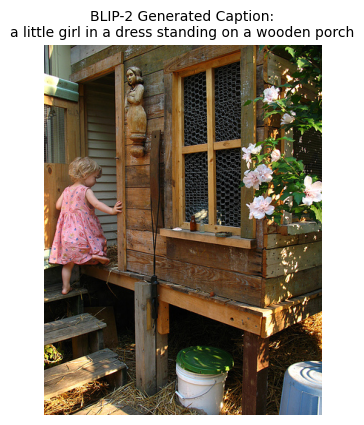

In [11]:
# 2. Load the Image
raw_image = load_image("/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg")
real_caption = "/kaggle/input/flickr8k/captions.txt"

if raw_image is None:
    print("Exiting due to image loading error.")
    exit() # Exit if image couldn't be loaded

# 3. Prepare Image for Model
inputs = processor(images=raw_image, return_tensors="pt").to(device, load_dtype)

# 4. Generate Caption
print("\nGenerating caption...")
caption = "(Generation failed)" # Default value
with torch.no_grad(): # Disable gradient calculation for inference
    # Generate output token IDs
    generated_ids = blip_model.generate(**inputs, max_new_tokens=50) # Control max caption length

    caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(f"\nGenerated Caption: {caption}")

try:
    plt.imshow(raw_image)
    plt.title(f"BLIP-2 Generated Caption:\n{caption}", fontsize=10)
    plt.axis('off')
    plt.show()
except Exception as e:
        print(f"\nNote: Could not display image. Ensure matplotlib is installed and working. Error: {e}")

In [24]:
def generate_and_compare_captions(
    image_path,
    custom_encoder,
    custom_decoder,
    custom_vocab,
    custom_transform,
    blip_processor,
    blip_model,
    ref_captions_map, # Pass the dict of reference captions {img_id: [cap1, cap2,...]}
    device
):
    """
    Loads an image, displays it, shows reference captions, and generates captions
    using both the custom model and BLIP-2 for comparison.
    """
    print("-" * 30)
    print(f"Generating captions for: {image_path}")
    print("-" * 30)

    # Assumes image_path exists
    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        return None, None

    # --- Load Image (once for all) ---
    raw_image = Image.open(image_path).convert('RGB')

    # --- Display Image ---
    plt.imshow(raw_image)
    plt.axis('off')
    plt.show()

    # --- Show Reference Captions ---
    img_id = os.path.splitext(os.path.basename(image_path))[0]
    print("\nReference Captions:")
    # Assumes img_id exists in ref_captions_map or handles default
    references = ref_captions_map.get(img_id, ["(Not found in reference map)"])
    for ref in references:
        print(f"  - {ref}")

    # --- Generate with Custom Model ---
    custom_caption_text = "(Custom model generation failed)"
    if custom_encoder is not None and custom_decoder is not None and custom_vocab is not None:
        custom_encoder.eval()
        custom_decoder.eval()
        # Assumes transform works
        image_transformed = custom_transform(raw_image).unsqueeze(0).to(device)
        custom_caption_text = generate_caption(image_path, custom_encoder, custom_decoder, custom_vocab, custom_transform, device)
        # with torch.no_grad():
        #     # Assumes encoder works
        #     features = custom_encoder(image_transformed)
        #     # Assumes decoder.sample is defined correctly as sample(self, features, vocab_ref, max_len=...)
        #     predicted_indices = custom_decoder.sample(features, custom_vocab, max_len=30)
        # Assumes itos lookup works
        # predicted_words = [custom_vocab.itos[idx] for idx in predicted_indices]
        # custom_caption_text = ' '.join(predicted_words)
    else:
         custom_caption_text = "(Custom model components not available)"
    print(f"\nCustom Model Caption:\n  --> {custom_caption_text}")


    # --- Generate with BLIP-2 Model ---
    blip2_caption_text = "(BLIP-2 generation failed)"
    if blip_processor is not None and blip_model is not None:
        blip_model.eval()
        load_dtype = torch.float16 if device == "cuda" else torch.float32
        # Assumes processor works
        inputs = blip_processor(images=raw_image, return_tensors="pt").to(device, load_dtype)
        with torch.no_grad():
            # Assumes generation works
            generated_ids = blip_model.generate(**inputs, max_new_tokens=30) # Using max_new_tokens=30 here
            # Assumes decode works
            blip2_caption_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    else:
        blip2_caption_text = "(BLIP-2 components not available)"
    img_display = Image.open(image_path); plt.imshow(img_display)
    plt.title(f"Generated Caption:\n{blip2_caption_text}", fontsize=10); plt.axis('off'); plt.show()
    print(f"\nBLIP-2 Model Caption:\n  --> {blip2_caption_text}")
    print("-" * 30)

    return custom_caption_text, blip2_caption_text

------------------------------
Generating captions for: /kaggle/input/flickr8k/Images/2892989340_bb7e0e5548.jpg
------------------------------


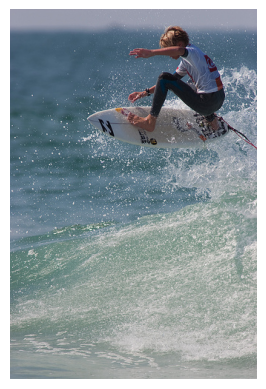


Reference Captions:
  - boy on surfboard in midair
  - surfer hangs in the air over the water
  - young man jumps with surfboard over the waves
  - young man surfing in the ocean
  - youth in white tshirt on white surfboard in the water


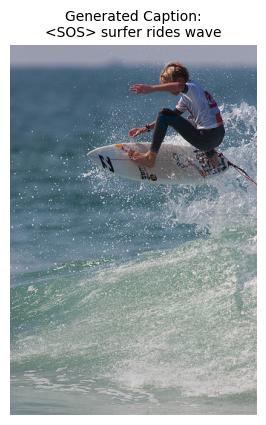


Custom Model Caption:
  --> <SOS> surfer rides wave


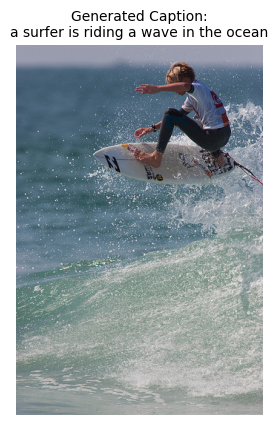


BLIP-2 Model Caption:
  --> a surfer is riding a wave in the ocean
------------------------------


In [25]:
# --- Generate and Compare Example ---
if test_indices:
     # Select a random image from the test set
     sample_original_idx = np.random.choice(test_indices)
     _, _, sample_img_id = dataset[sample_original_idx] # Get img_id from the full dataset
     test_image_path = os.path.join(IMAGES_PATH, sample_img_id + '.jpg')

     # Call the combined generation and comparison function
     generate_and_compare_captions(
         image_path=test_image_path,
         custom_encoder=encoder,         # Might be None if load failed
         custom_decoder=decoder,         # Might be None if load failed
         custom_vocab=saved_vocab,       # Might be None if load failed
         custom_transform=transform,
         blip_processor=blip_processor,  # Might be None if load failed
         blip_model=blip_model,          # Might be None if load failed
         ref_captions_map=cleaned_captions_map, # Pass the ground truth map
         device=device
     )

else:
     print("\nTest indices not available, cannot generate random sample caption.")